In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Creating a univariate and multivariate decision tree :

In [ ]:
## getting the data :
df = pd.DataFrame()
# df.columns = ['Age','Salary($)','College Degree']
df['Age'] = [24,53,23,25,32,52,22,43,52,48]
df['Salary($)'] =[40000,52000,25000,77000,48000,110000,	38000,44000,27000,65000]
df['College Degree'] = ['Yes','No','No','Yes','Yes','Yes','Yes','No','No','Yes']
df

,Age,Salary($),College Degree
0,24,40000,Yes
1,53,52000,No
2,23,25000,No
3,25,77000,Yes
4,32,48000,Yes
5,52,110000,Yes
6,22,38000,Yes
7,43,44000,No
8,52,27000,No
9,48,65000,Yes


In [ ]:
df['coll'] = (df['College Degree'] == 'No')

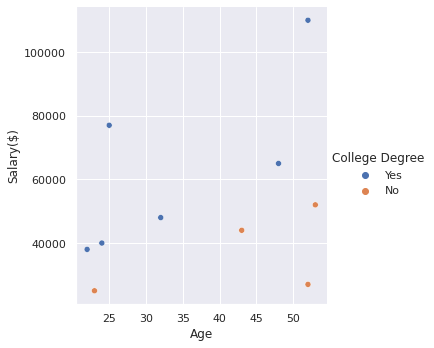

In [ ]:
## plotting the data:
sns.set_theme(style="darkgrid")
sns.relplot(data=df, x="Age", y="Salary($)", hue="College Degree")

In [ ]:
## Before we implement the functions let's try to test out the individual functions first :

# 1. Entropy is a measure for randomness in the data. At each node we need to calculate the 
# entropy of the node to measure its impurity

# Here 1e-9 is the min info gain :
def entropy(y):
  v = y.value_counts()/y.shape[0]
  entropy = np.sum(-v*np.log2(v+1e-9))
  return(entropy)


# InformationGain for Classification = E(d) –∑ ( |s|/|d| * E(s) )

def information_gain(y, split, func=entropy):
  a = sum(split)
  b = split.shape[0] - a
  
  if(a == 0 or b == 0): 
    ig = 0
  
  else:
    if y.dtypes != 'O':
      ig = y.var() - (a/(a+b)* (y[split]).var() ) - (b/(a+b)* (y[-split]).var() )
    else:
      ig = func(y)-a/(a+b)*func(y[split])-b/(a+b)*func(y[-split])
  return ig

In [ ]:
# Let's try to find the information gain of a particular split:
## 'College degree ' = True and 'Salary <= 48000'
information_gain(df['coll'], df['Age'] <= 40 )

0.016666666666666663

In [ ]:
## Now that we have seen the individual functions run :

# using an OOP implementation is better for decesion trees as each node has its own attributes :

class Node():
    def __init__(self, feature_index=None, threshold=None, left=None, right=None, info_gain=None, value=None): 
        # For the node where the decision takes place 
        self.feature_index = feature_index
        self.threshold = threshold
        self.left = left
        self.right = right
        self.info_gain = info_gain
        # for the end (leaf) node :
        self.value = value

In [ ]:
# Creating a class for all the implementation functions :

class DecisionTree():
    def __init__(self, min_samples_split=2, max_depth=2):
        
        # root
        self.root = None
        
        # Defining the stopping conditions for the splits
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth

    
    def information_gain(self, parent, l_child, r_child):

      # defining the weights of each child on the basis of the parent split
        weight_l = len(l_child) / len(parent)
        weight_r = len(r_child) / len(parent)
      # Calculating the final gain
        gain = self.entropy(parent) - (weight_l * self.entropy(l_child) + weight_r * self.entropy(r_child))

        return gain
    
    def entropy(self, y):
      # using all the categorical lables from the ['taget data']
        all_lab = np.unique(y)
        entropy = 0
        for lab in all_lab:
            prob = len(y[y == lab]) / len(y)
            entropy += -prob * np.log2(prob)
        return entropy
        

# Now we need to implement functions to build the tree : 

    def build_tree(self, dataset, curr_depth=0):
        
        # splitting the data :
        X, Y = dataset[:,:-1], dataset[:,-1]
        count_samp, count_feat = np.shape(X)
        
        # we need to split the nodes until we match our stopping conditions :

        if curr_depth <= self.max_depth and count_samp >= self.min_samples_split :

            # best split
            best_split = self.get_best_split(dataset, count_samp, count_feat)

            # checking the information gain

            if best_split["info_gain"] > 0:
                # left recurssion
                left_subtree = self.build_tree(best_split["dataset_left"], curr_depth+1)

                # right recurssion
                right_subtree = self.build_tree(best_split["dataset_right"], curr_depth+1)

                # best decision node
                return Node(best_split["feature_index"], best_split["threshold"], 
                            left_subtree, right_subtree, best_split["info_gain"])
        
        # end nodes (leaf nodes)
        end_val = self.calculate_leaf_value(Y)
        # return leaf node
        return Node(value=end_val)
    
# Getting the best split for each at each of the nodes :

    def get_best_split(self, dataset, num_samples, count_feat):
        
        # setting the max information gain to negative infinity 
        max_info_gain = -float("inf")

        # storing the best split in a dict
        best_split = {}
      
        # iterating over all the features in the set :
        for feature_index in range(count_feat):
            feature_values = dataset[:, feature_index]
            all_thresholds = np.unique(feature_values)

            # iterating over all the features in the data :
            for thresh in all_thresholds:

                # present split :
                dataset_left, dataset_right = self.split(dataset, feature_index, thresh)

                # confirming that the childs are not null :
                if len(dataset_left) > 0 and len(dataset_right) > 0:
                    y, left_y, right_y = dataset[:, -1], dataset_left[:, -1], dataset_right[:, -1]

                    # infor gain
                    p_info_gain = self.information_gain(y, left_y, right_y)

                    # cheking the updating the split :
                    if p_info_gain > max_info_gain:                 # which was set to negative infinity
                        best_split["feature_index"] = feature_index
                        best_split["threshold"] = thresh
                        best_split["dataset_left"] = dataset_left
                        best_split["dataset_right"] = dataset_right
                        best_split["info_gain"] = p_info_gain
                        max_info_gain = p_info_gain
                        
        # return best split
        return best_split

# the function to split the data nodes :

    def split(self, dataset, feature_index, threshold):
        
        # using the feature index to create the splitting point
        dataset_left = np.array([r for r in dataset if r[feature_index] <= threshold])
        dataset_right = np.array([r for r in dataset if r[feature_index] > threshold])
        return dataset_left, dataset_right
    
# Calculating each leaf node :     
    def calculate_leaf_value(self, Y):
        leaf = list(Y)
        return max(leaf, key=leaf.count)


# Creating the function for drawing the tree :

    def print_tree(self, tree=None, indent=" "):
        
        # empty tree
        if not tree:
            tree = self.root
        
        if tree.value is not None:
            print(tree.value)

        else:
            print(" Split Condition : ")
            print("X_"+ str(tree.feature_index), " <= ", tree.threshold, "\n", "Information Gain : ", tree.info_gain)
            print("%sleft:" % (indent), end="")
            self.print_tree(tree.left, indent + indent)
            print("%sright:" % (indent), end="")
            self.print_tree(tree.right, indent + indent)

# Final functions to fit and predict the data :

    def fit(self, X, Y):
        data = np.concatenate((X, Y), axis=1)
        self.root = self.build_tree(data)

# Prediction for each of the data points :
    def make_prediction(self, x, tree):  
        if tree.value!=None: 
          return tree.value
        
        feature_val = x[tree.feature_index]

        if feature_val <= tree.threshold:
            return self.make_prediction(x, tree.left)
        else:
            return self.make_prediction(x, tree.right)

# final predictions :
    def predict(self, X):
        preditions = [self.make_prediction(x, self.root) for x in X]
        return preditions
    

In [ ]:
df = df.drop('coll',axis=1)

In [ ]:
df

,Age,Salary($),College Degree
0,24,40000,Yes
1,53,52000,No
2,23,25000,No
3,25,77000,Yes
4,32,48000,Yes
5,52,110000,Yes
6,22,38000,Yes
7,43,44000,No
8,52,27000,No
9,48,65000,Yes


In [ ]:
# Final Implementation :
# target values
Y = df.iloc[:, -1].values.reshape(-1,1)
X = df.iloc[:, :-1].values

# train_test_split :

from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.1, random_state=6)

In [ ]:
# Final Predictions :
cls = DecisionTree(min_samples_split=2, max_depth=20)
cls.fit(X_train,Y_train)
cls.print_tree()

 Split Condition : 
X_1  <=  52000 
 Information Gain :  0.2516291673878229
 left: Split Condition : 
X_0  <=  32 
 Information Gain :  0.4591479170272448
  left: Split Condition : 
X_1  <=  25000 
 Information Gain :  0.8112781244591328
    left:No
    right:Yes
  right:No
 right:Yes


#### We can see that the tree depth is 3, and the information gain is listed beside.

In [ ]:
Y_pred = cls.predict(X_test) 
from sklearn.metrics import accuracy_score
accuracy_score(Y_test, Y_pred)

1.0

In [ ]:
from matplotlib import pyplot as plt
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier 
from sklearn import tree

cls = DecisionTreeClassifier(criterion='entropy',random_state=6)
model = cls.fit(X_train,Y_train)

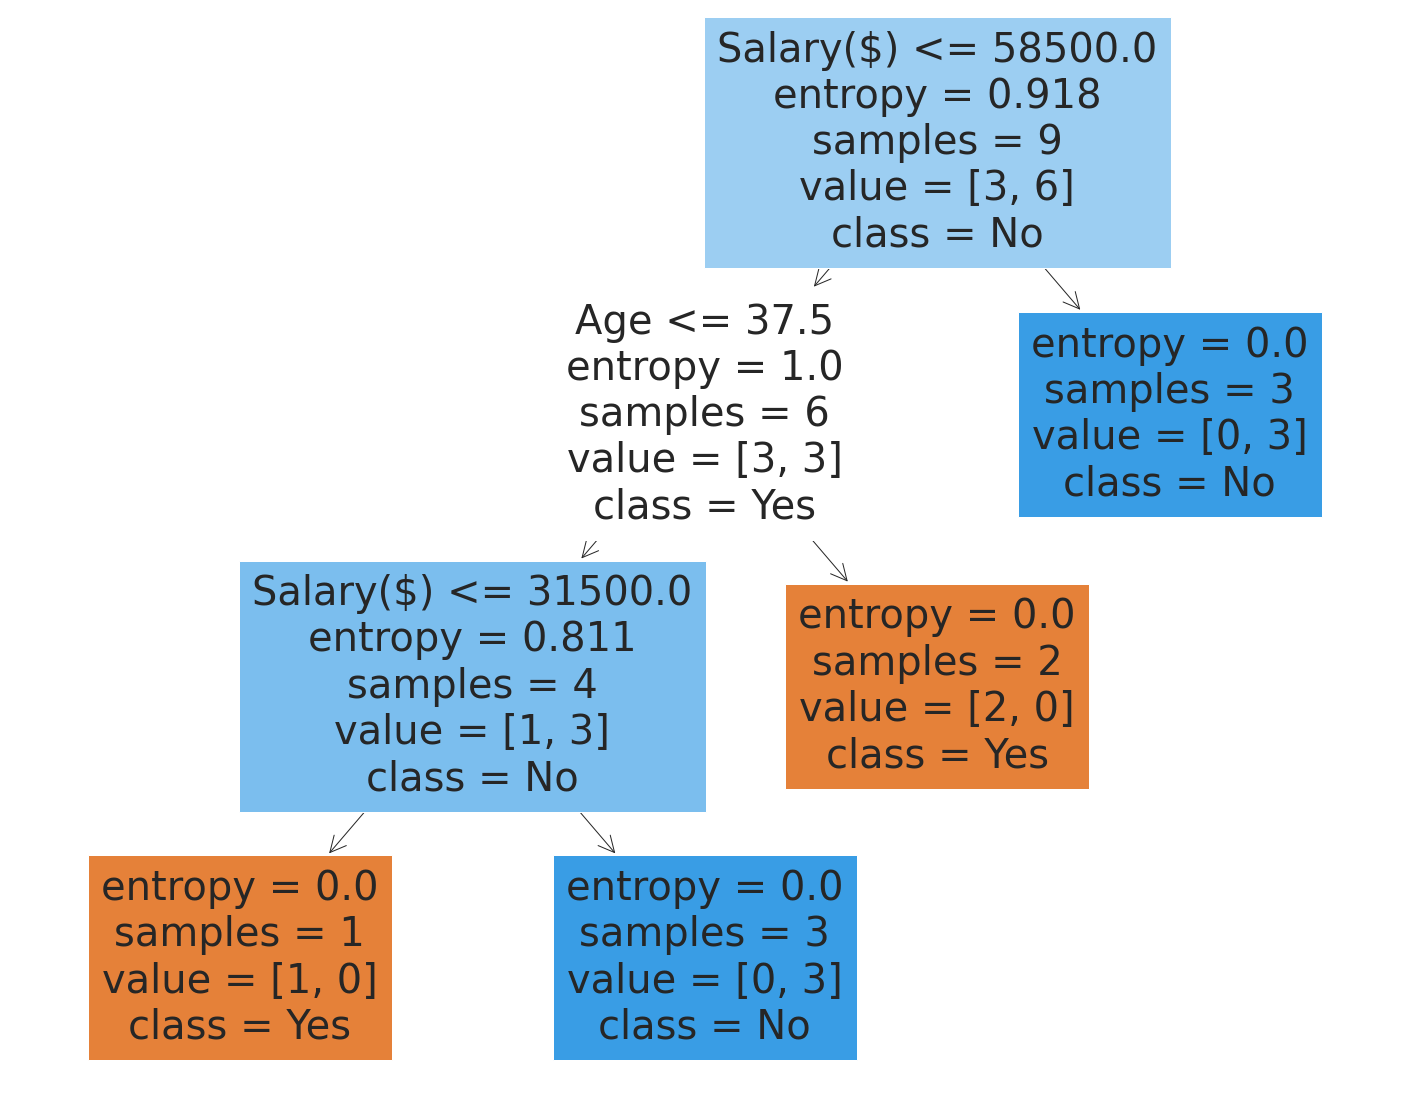

In [ ]:
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(cls, 
                   feature_names=df.columns,  
                   class_names=df['College Degree'].value_counts().index,
                   filled=True)

____
## Trying to implement perceptron aprroach using :
- https://towardsdatascience.com/perceptron-algorithm-in-python-f3ac89d2e537

- https://machinelearningmastery.com/implement-perceptron-algorithm-scratch-python/

In [ ]:
# using linear regression as information split parameter :

def reg_coef(x, y):
    n = np.size(x)
    m_x = np.mean(x)
    m_y = np.mean(y)

    S_xy = np.sum(y*x) - n*m_y*m_x
    S_xx = np.sum(x*x) - n*m_x*m_x
  
    # calculating regression coefficients
    alpha = S_xy / S_xx
    beta = m_y - alpha*m_x
  
    return (alpha, beta)

alpha, beta =  reg_coef(df['Age'], df['Salary($)'])
alpha = np.round(alpha,2)
beta = np.round(beta,2)

print(alpha,beta)

648.98 28328.31


In [ ]:
## implementing the perceptron approach :

def step_func(z):
        return 1.0 if (z > 0) else 0.0


def perceptron(X, y, lr, epochs):
    
    # X --> Inputs.
    # y --> labels/target.
    # lr --> learning rate.
    # epochs --> Number of iterations.
    
    # m-> number of training examples
    # n-> number of features 
    m, n = X.shape
    
    # Initializing parapeters(theta) to zeros.
    # +1 in n+1 for the bias term.
    theta = np.zeros((n+1,1))
    
    # Empty list to store how many examples were 
    # misclassified at every iteration.
    n_miss_list = []
    
    # Training.
    for epoch in range(epochs):
        
        # variable to store #misclassified.
        n_miss = 0
        
        # looping for every example.
        for idx, x_i in enumerate(X):
            
            # Insering 1 for bias, X0 = 1.
            x_i = np.insert(x_i, 0, 1).reshape(-1,1)
            print(x_i.T)
            
            # Calculating prediction/hypothesis.
            y_hat = step_func(np.dot(x_i.T, theta))
            print(y_hat)
            
            # Updating if the example is misclassified.
            if (np.squeeze(y_hat) - y[idx]) != 0:
                theta += lr*((y[idx] - y_hat)*x_i)
                
                # Incrementing by 1.
                n_miss += 1
        
        # Appending number of misclassified examples
        # at every iteration.
        n_miss_list.append(n_miss)
        
    return theta, n_miss_list

In [ ]:
df.loc[df['College Degree']=='Yes', 'College Degree'] = 1
df.loc[df['College Degree']=='No', 'College Degree'] = 0
df

,Age,Salary($),College Degree
0,24,40000,1
1,53,52000,0
2,23,25000,0
3,25,77000,1
4,32,48000,1
5,52,110000,1
6,22,38000,1
7,43,44000,0
8,52,27000,0
9,48,65000,1


In [ ]:
y = df['College Degree']

In [ ]:
theta, miss_l = perceptron(X, y, 0.5, 100)

[[    1    24 40000]]
0.0
[[    1    53 52000]]
1.0
[[    1    23 25000]]
0.0
[[    1    25 77000]]
0.0
[[    1    32 48000]]
1.0
[[     1     52 110000]]
1.0
[[    1    22 38000]]
1.0
[[    1    43 44000]]
1.0
[[    1    52 27000]]
1.0
[[    1    48 65000]]
0.0
[[    1    24 40000]]
1.0
[[    1    53 52000]]
1.0
[[    1    23 25000]]
1.0
[[    1    25 77000]]
0.0
[[    1    32 48000]]
1.0
[[     1     52 110000]]
1.0
[[    1    22 38000]]
1.0
[[    1    43 44000]]
1.0
[[    1    52 27000]]
1.0
[[    1    48 65000]]
0.0
[[    1    24 40000]]
1.0
[[    1    53 52000]]
1.0
[[    1    23 25000]]
1.0
[[    1    25 77000]]
0.0
[[    1    32 48000]]
1.0
[[     1     52 110000]]
1.0
[[    1    22 38000]]
1.0
[[    1    43 44000]]
1.0
[[    1    52 27000]]
1.0
[[    1    48 65000]]
0.0
[[    1    24 40000]]
1.0
[[    1    53 52000]]
1.0
[[    1    23 25000]]
0.0
[[    1    25 77000]]
0.0
[[    1    32 48000]]
1.0
[[     1     52 110000]]
1.0
[[    1    22 38000]]
1.0
[[    1    43 44000]]
1.0


Above, we got the values of alpha and beta, but we didn't quite understand how to implement it.
We were not able to find enough resources for its implementation.
___

## Advantages and disadvantages :
In my opinion, 

- Multivariate trees are more complex to implement.
- Though mutivariate trees might be able to fit the local data better than univariate trees, it seems like a less generalised approach.
- Random Forest uses mutiple univariate trees and might be a better fit to the data.

However,

- Mutivariate trees allow us to combine the best features of regression and decision trees, which might make it a better classifier.


---